In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
images = np.load('images.npy')
labels = np.load('labels.npy')
test_images = np.load('images_sub.npy')

In [ ]:
images = images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
labels = to_categorical(labels, num_classes=26)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 128)       

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
250/250 [==============================] - 2s 6ms/step - loss: 3.1987 - accuracy: 0.0615 - val_loss: 2.8828 - val_accuracy: 0.1452 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - 1s 5ms/step - loss: 2.2061 - accuracy: 0.3314 - val_loss: 1.4642 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 1s 5ms/step - loss: 1.2658 - accuracy: 0.6039 - val_loss: 1.0058 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - 1s 5ms/step - loss: 0.9052 - accuracy: 0.7171 - val_loss: 0.8191 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 0.7062 - accuracy: 0.7743 - val_loss: 0.7670 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 6/50
250/250 [==============================] - 1s 5ms/step - loss: 0.5758 - accuracy: 0.8169 - val_loss: 0.6809 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 7/50
250/250 [==============================] - 1s 5ms/step - lo

In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
submission = pd.DataFrame({'Id': range(len(predicted_classes)), 'Category': predicted_classes}).to_csv('submission.csv', index=False)

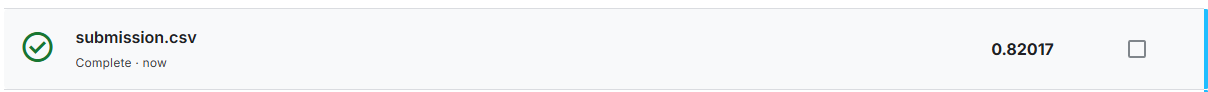

**Попробуем улучшить результат. Добавим padding, чтобы сохранить размерность, BatchNormalization и Dropout после каждого блока для борьбы с переобучением**

In [ ]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(26, activation='softmax')
    ])

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

**Сделаем обучение с аугментацией данных**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

history = model.fit(
    ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=False).flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
250/250 [==============================] - 11s 39ms/step - loss: 3.8744 - accuracy: 0.0501 - val_loss: 3.5232 - val_accuracy: 0.0235 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 9s 37ms/step - loss: 3.2135 - accuracy: 0.1159 - val_loss: 2.6720 - val_accuracy: 0.2290 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 9s 38ms/step - loss: 2.2717 - accuracy: 0.3425 - val_loss: 1.5988 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 9s 38ms/step - loss: 1.7006 - accuracy: 0.4921 - val_loss: 1.0638 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 10s 38ms/step - loss: 1.3562 - accuracy: 0.5908 - val_loss: 0.8826 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 9s 38ms/step - loss: 1.1571 - accuracy: 0.6443 - val_loss: 0.7206 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 9

In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
submission = pd.DataFrame({'Id': range(len(predicted_classes)), 'Category': predicted_classes}).to_csv('submission.csv', index=False)

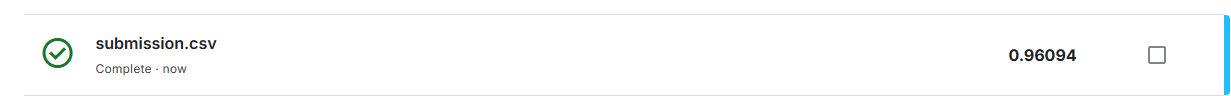